In [6]:
import numpy as np
import cytnx as ct
import matplotlib.pyplot as plt

In [7]:
J=1
h=0
Lmax=10
beta = 1/np.geomspace(2.26,2.38,50)

In [8]:
def get_delta(beta,h):
    delta_t = ct.zeros((2,2,2,2))
    delta_t[0,0,0,0] = np.exp(beta*h)
    delta_t[1,1,1,1] = np.exp(-beta*h)
    delta_ut = ct.UniTensor(delta_t, rowrank=2)
    return delta_ut

In [9]:
def merge_y(T1,T2):
    net = ct.Network('./network/merge_y.net')
    net.PutUniTensors(['T1','T2'],[T1,T2])
    L2 = net.Launch()
    L2.combineBonds([1,2])
    L2.combineBonds([3,4])
    return L2

In [10]:
def get_T(J,beta,delta_ut):
    W=(np.exp(np.array([[J*beta, -J*beta],[-J*beta,J*beta]])))
    W_t = ct.from_numpy(W)
    S_t,U_t,Vd_t = ct.linalg.Svd(W_t)
    M_t = (U_t @ ct.linalg.Diag(S_t.Pow(0.5)))
    M_ut = ct.UniTensor(M_t,rowrank=1)
    net = ct.Network('./network/transfer.net')
    net.PutUniTensors(['delta','M1','M2','M3','M4'],
                  [delta_ut,M_ut,M_ut,M_ut,M_ut])
    return net.Launch()

In [11]:
%%time
TM = {}
L = {}
u = {}
xi = {}
E = {}
for i in range(2,Lmax+1):
    xi[i] = []
for i in beta:
    delta_ut = get_delta(i,h)
    T_ut = get_T(J,i,delta_ut)
    for j in range(2,Lmax+1):
        #print(j)
        if j==2:
            L[j]=merge_y(T_ut,T_ut)
        else:
            L[j]=merge_y(L[j-1],T_ut)
        TM[j] = L[j].get_block().numpy()
        TM[j] = np.trace(TM[j],axis1=0,axis2=3)
        u[j],_ = np.linalg.eigh(TM[j])
        u[j] = u[j][::-1]
        E[j] = -np.log(u[j])
        xi[j].append(1/(E[j][1]-E[j][0]))

CPU times: user 1min 3s, sys: 18 s, total: 1min 21s
Wall time: 34.5 s


In [12]:
for i in range(2,Lmax+1):
    xi[i]=np.array(xi[i])
    xi[i]=xi[i]/i

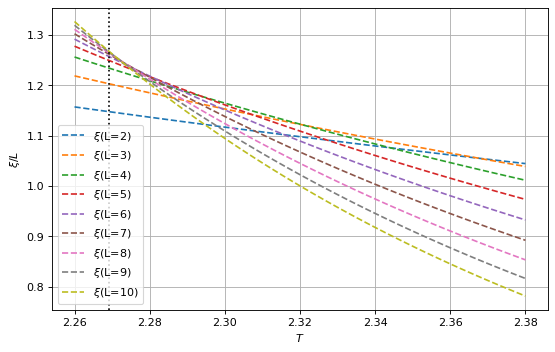

In [13]:
plt.figure(figsize=(8,5),dpi=80)
for i in range(2,Lmax+1):
    plt.plot(1/beta,xi[i],'--',label='$\\xi$(L=%d)' %i)
#for i in range(3,Lmax+1):
    #plt.plot(1/beta[np.argmin(np.abs(xi[i]-xi[i-1]))],xi[i][np.argmin(np.abs(xi[i]-xi[i-1]))],'r.')
plt.axvline(x=2/np.log(1+np.sqrt(2)),ls=':',c='k')
plt.legend()
plt.xlabel('$T$')
plt.ylabel('$\\xi/L$')
plt.grid()
plt.show()

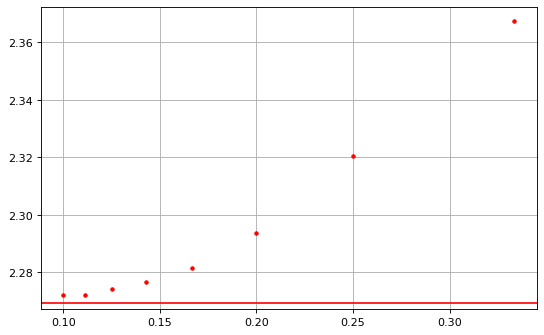

In [14]:
plt.figure(figsize=(8,5),dpi=80)
for i in range(3,Lmax+1):
    plt.plot(1/i,1/beta[np.argmin(np.abs(xi[i]-xi[i-1]))],'r.')
plt.axhline(y=2/np.log(1+np.sqrt(2)),c='r')
plt.grid()
plt.show()